<div class="alert alert-block alert-info">

##  Praxisbeispiel: Grayscale-Filter (Graustufen-Filter)

#### Ein Grayscale-Filter (Graustufenfilter) ist ein Werkzeug, das in der Bildbearbeitung verwendet wird, um ein farbiges Bild in ein Graustufenbild zu konvertieren. $\newline$
<div>
    <img src="kingfisher-grayscale-filter.png" style="width:50%;"/>
    </div>
    
#### <b>Anwendungen:</b> Textur- und Strukturanalyse, Datenreduktion, Ästhetik, etc.

#### <b>Einfachste Umsetzung:</b> Die RGB-Kanäle werden für jedes Pixel durch das arithmetische Mittel ersetzt $R=G=B:=\frac{R+G+B}{3}$.
</div>

# 1. Pure Python

In [1]:
import time #for profiling
from PIL import Image #PIL = Python Imaging Library

In [25]:
def grayscale_filter_py(pixel_size, bytes):
    """Applies grayscale filter to bytes of an RGB image"""
    
    for i in range(0,3*pixel_size,3):   
        r,g,b = bytes[i], bytes[i+1], bytes[i+2]
        avg = (r+g+b)//3
        bytes[i] = bytes[i+1] = bytes[i+2] = avg
    
    return None

<div class="alert alert-block alert-success">

### Aufgabe 1: 
#### Warum wird der Operator // zur Division verwendet?
#### Warum gibt die Funktion nichts zurück?

</div>

### Testbild

In [2]:
test_image = Image.open('C:/Users/LENOVO/Pictures/Hochschule_Trier/trier.jpg') #test image from Pixabay
print(test_image.mode, test_image.size)

RGB (1920, 1282)


In [29]:
def show_image(image):
    """Auxiliary function: Displays a smaller picture without altering the original"""
    thumbnail = image.resize((test_image.width//5, test_image.height//5))
    print(image.mode, image.size)
    display(thumbnail)

RGB (1920, 1282)


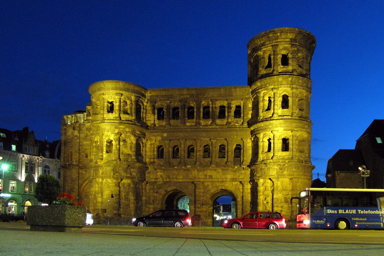

In [30]:
show_image(test_image)

### Anwendung und Profiling

In [31]:
t0 = time.time()
img_bytes = bytearray(test_image.tobytes())
size = test_image.width*test_image.height
grayscale_filter_py(size, img_bytes)
result = Image.frombytes(test_image.mode, test_image.size, bytes(img_bytes)) 
t1 = time.time()
delta_t_py = t1-t0
print("Execution time (Python): ", round(delta_t_py,3), " seconds.")

Execution time (Python):  1.404  seconds.


RGB (1920, 1282)


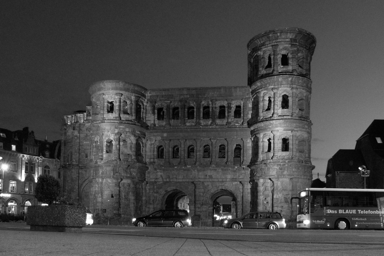

In [34]:
show_image(result)

# 2. C-Bibliothek

<div class="alert alert-block alert-success">
    
### Aufgabe 2: 
#### In Python iterieren wir über die Bytes eines bytearray-objects. Welchen Datentyp verwenden wir in C?
</div>

In [6]:
import ctypes

In [7]:
c_lib =ctypes.CDLL("../C/Grayscale/bin/Release/LibGrayscale.dll")

In [8]:
t0 = time.time()
img_bytes = test_image.tobytes()
size = test_image.width*test_image.height
c_lib.grayscale_filter(size, img_bytes)
result = Image.frombytes(test_image.mode, test_image.size, img_bytes) 
t1 = time.time()
delta_t_C = t1-t0
print("Execution time (C Lib.):", round(delta_t_C,3), " seconds.")

Execution time (C Lib.): 0.024  seconds.


RGB (1920, 1282)


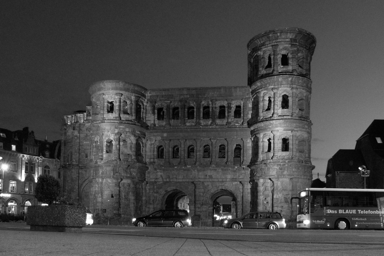

In [9]:
show_image(result)

In [13]:
print("Factor: "+ str(round(delta_t_py/delta_t_C,1)))

Factor: 65.4


# 3. C-Extension als eigenständiges Modul

In [6]:
import grayscale_module-1.0 as gs

SyntaxError: invalid syntax (1895485218.py, line 1)

In [5]:
help(gs)

Help on module grayscale_module:

NAME
    grayscale_module - Python-Interface to Grayscale Filter implemented in C

FUNCTIONS
    grayscale(...)
        Grayscale Filter

FILE
    c:\users\lenovo\anaconda3\lib\site-packages\grayscale_module.cp39-win_amd64.pyd




In [3]:
gs?

Type:        module
String form: <module 'grayscale_module' from 'C:\\Users\\LENOVO\\anaconda3\\lib\\site-packages\\grayscale_module.cp39-win_amd64.pyd'>
File:        c:\users\lenovo\anaconda3\lib\site-packages\grayscale_module.cp39-win_amd64.pyd
Docstring:   Python-Interface to Grayscale Filter implemented in C

In [21]:
t0 = time.time()
img_bytes = test_image.tobytes()
#try:
gs.grayscale(size, img_bytes)
#except RuntimeError as e:
#    print(f"Error ocurred: {e}")
result = Image.frombytes(test_image.mode, test_image.size, img_bytes)
t1 = time.time()
delta_t_C_Module = t1-t0
print("Execution time (C Module):", round(delta_t_C_Module,3), " seconds.")

Execution time (C Module): 0.016  seconds.


RGB (1920, 1282)


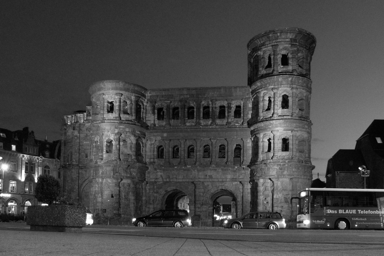

In [22]:
show_image(result)

In [23]:
print("Factor: "+ str(round(delta_t_py/delta_t_C_Module,1)))

Factor: 96.2


#### Results

In [24]:
from tabulate import tabulate

In [40]:
head = ["Execution Time [sec]", "Python Execution Time / Execution Time"]

In [41]:
data = [
    ["Pure Python", round(delta_t_py,3), 1.0],
    ["C DLL", round(delta_t_C,3), round(delta_t_py/delta_t_C,1)],
    ["C Module", round(delta_t_C_Module,3), round(delta_t_py/delta_t_C_Module,1)]]

In [42]:
print(tabulate(data, headers=head, tablefmt="fancy_grid"))

╒═════════════╤════════════════════════╤══════════════════════════════════════════╕
│             │   Execution Time [sec] │   Python Execution Time / Execution Time │
╞═════════════╪════════════════════════╪══════════════════════════════════════════╡
│ Pure Python │                  1.561 │                                      1   │
├─────────────┼────────────────────────┼──────────────────────────────────────────┤
│ C DLL       │                  0.025 │                                     62.1 │
├─────────────┼────────────────────────┼──────────────────────────────────────────┤
│ C Module    │                  0.016 │                                     96.2 │
╘═════════════╧════════════════════════╧══════════════════════════════════════════╛


#### Appendix

It is tempting to implement the grayscale filter in Python on a pixel level, instead of
byte level. However, this is extremely slow! Example below:

In [46]:
def grayscale_filter_pixelwise(image):
    """Applies grayscale filter to image and returns gray image"""
    
    width, height = image.size
    result = Image.new(image.mode, image.size) 
    
    for x in range(width):
        for y in range(height):            
            r, g, b = image.getpixel((x,y))
            avg = (r+g+b)//3 
            result.putpixel((x,y), (avg,avg,avg)) # Extremely slow function!

    return result

In [50]:
t0 = time.time()
result = grayscale_filter_pixelwise(test_image)
t1 = time.time()
delta_t_pixels = t1-t0
print("Execution time (Python, pixelwise): ", round(delta_t_pixels,3), " seconds.")

Execution time (Python, pixelwise):  6.582  seconds.
